### Traffic Sign Classification in Czech Republic

This project focuses on the *classification of traffic signs* in the **Czech Republic** using *machine learning techniques*.

* **Dataset**:
  The dataset comprises images collected through various sources, including personal captures near locations like universities, Billa, Kaufland, and street views of the Ceske Budejovice area. With approximately 800 images initially captured, the dataset was filtered and cleaned, resulting in 569 samples representing 26 different classes.

* **Data Preparation**:
  To ensure accurate labeling, *Wikipedia* was utilized as a reference for naming each class. Subsequently, the dataset underwent preprocessing, including balancing the sample counts across classes through image augmentation techniques.

* **Training**:
  The balanced dataset was then split into training and testing sets for model development and evaluation. Two models were implemented: a basic convolutional neural network and a ResNet50 model. The models were trained and evaluated, achieving satisfactory accuracy on the test set.

* **Testing**:
  The models were tested on new, unseen images, demonstrating their effectiveness in real-world scenarios. Overall, this project aims to contribute to the development of robust traffic sign classification systems tailored for the Czech Republic.


#### Directory structure

This folder contains all the files necessary for training and testing Object Detection/Classification of Traffic Signs in the Czech Republic.

**Folders**
- **notebook.ipynb**: Python notebook file to train and test the model
- **Dataset directory**: This folder contains all the collected images (for training) and their annotations in a JSON file (using the labelme tool).
- **cropped_ds directory**: Contains all the classes directories with respective samples used for training.
- **augmented directory**: Contains all augmented images.
- **test_inp_data directory**: Contains images with annotations to test the model.
- **test_out_data directory**: Contains outputs generated by both models in respective directories (Basic_model: B_output, Resnet_model: R_output)

**Note**: The data has been removed for both 'test_inp_data' and 'test_out_data' due to size challenges.

**Files**
- **ds_info.csv**: Holds data for all the images in the Dataset directory with their labels and other details.
- **ds_info_cropped.csv**: Contains data for all cropped images in the cropped_ds directory with their labels and other details.
- **final_csv.csv**: Contains data of all the samples used for training, including original and augmented data.

In [ ]:
# Importing Libraries
import os
import json
from PIL import Image
import cv2
import glob
import base64
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
ds_path = 'Dataset'
cropped_ds = "cropped_ds"
input_csv = "ds_info_cropped.csv"
final_data = "final_csv.csv"

### Dataset

The dataset comprises approximately **800 images** collected from various sources, including personal captures near university, Billa, Kaufland, and street views of the Ceske Budejovice area. During the data filtering and cleaning process, **569 samples** representing **26 different classes** were selected. For accurate labeling, the [LabelMe tool](https://github.com/labelmeai/labelme) was utilized. Additionally, *Wikipedia* serves as a reference for class naming.
[Wikipedia Link](https://en.wikipedia.org/wiki/Road_signs_in_the_Czech_Republic)


In [87]:
# Reading Dataset
df = pd.read_csv(input_csv)
df.head()

,Unnamed: 0,label,path,height,width,x1,y1,x2,y2
0,0,cycleway,cropped_ds\cycleway\0.png,57,62,55,230,117,287
1,1,pedestrian,cropped_ds\pedestrian\1.png,56,53,280,122,333,178
2,2,no_stopping,cropped_ds\no_stopping\2.png,29,35,149,120,184,149
3,3,no_stopping,cropped_ds\no_stopping\3.png,50,55,376,155,431,205
4,4,no_entry_for_vehicles,cropped_ds\no_entry_for_vehicles\4.png,21,18,119,153,137,174


### Dataset Formatting

As observed in the dataset preview, the images have varying dimensions, requiring standardization for model training. Additionally, since we are utilizing RGB images, each image has three channels. Therefore, to ensure consistency in input dimensions and channel configuration, preprocessing steps will be implemented to resize all images to a uniform size and maintain a consistent channel format across the dataset.


In [88]:
# Configurations
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
NUM_CHANNELS = 3

#### Class Count Analysis

To ensure a balanced dataset, it is essential to examine the count of samples for each class. Classes with fewer samples than the specified minimum threshold (50) will be relabeled as the 'other' class. Following this adjustment, the original 26 classes were consolidated into a total of 4 classes, with the corresponding sample counts as follows:
- 'other': 354
- 'parking': 85
- 'no_entry_for_vehicles': 70
- 'no_stopping': 61


In [89]:
# Listing counts
min_samples = 50 # Every class should have min number of samples, else it will be changed to other

counts = df['label'].value_counts().to_dict()

df['label'] = df['label'].apply(lambda x: 'other' if counts[x]<min_samples else x)
print('Final Classes:')
counts = df['label'].value_counts().to_dict()
print(counts)

Final Classes:
{'other': 354, 'parking': 85, 'no_entry_for_vehicles': 70, 'no_stopping': 61}


### Addressing Class Imbalance through Data Augmentation

Class imbalance, as observed in the initial class count analysis, can significantly impact the performance of machine learning models, leading to *biased predictions* and *reduced accuracy*, especially for minority classes. To mitigate this issue, data augmentation technique is used.

---

The following method applies **rotation** and **horizontal flipping** to the existing images to balance the dataset.


In [90]:
def augmentation(path):
    try:
        image = cv2.imread(path)
        # Rotate the image by 45 degrees
        (rows, cols) = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 45, 1)
        rotated_image = cv2.warpAffine(image, M, (cols, rows))
        # Flip the image horizontally
        flipped_image = cv2.flip(image, 1)
        return [rotated_image, flipped_image]
    except Exception as e:
        print(e)
        return []


The objective is to equalize the number of samples across different classes while simultaneously saving the augmented images and updating the input dataframe for future use.

**Total Images Generated:** 593

**New Counts of Each Class:**
- 'other': 354
- 'no_stopping': 354
- 'no_entry_for_vehicles': 354
- 'parking': 354

In [91]:
# Image augmentation to balance Dataset
max_samples = max(counts.values())
aug_path = "augmented"


for item in counts.items():
    if item[1] < max_samples:
        samples = item[1]
        while samples<max_samples:
            temp_df = df.loc[df['label'] == item[0]]
            # print(temp_df.head())
            for row in temp_df.iterrows():
                # print(row)
                aug_type = 0
                for img in augmentation(row[1]['path']):
                    cv2.imwrite(os.path.join(aug_path, row[1]['path'].split('\\')[-1].split('.')[0] + "_" + str(aug_type)+".png"), img)
                    df.loc[len(df.index)] = [0,row[1]['label'], os.path.join(aug_path, row[1]['path'].split('\\')[-1].split('.')[0] + "_" + str(aug_type)+".png"), row[1]['height'], row[1]['width'],
                                            row[1]['x1'], row[1]['y1'], row[1]['x2'], row[1]['y2']]
                    aug_type+=1
                    samples+=1
                    if samples>=max_samples: break
                if samples>=max_samples: break
print("Total images generated: ", len(os.listdir(aug_path)))
counts = df['label'].value_counts().to_dict()
print("New counts of each class: ", counts)

Total images generated:  593
New counts of each class:  {'other': 354, 'no_stopping': 354, 'no_entry_for_vehicles': 354, 'parking': 354}


In [92]:
# Saving final data
df.to_csv(final_data)

In [1]:
# Total Classes
NUM_CLASSES = len(counts.items())
print("Total classes:", NUM_CLASSES)

Total classes: 4


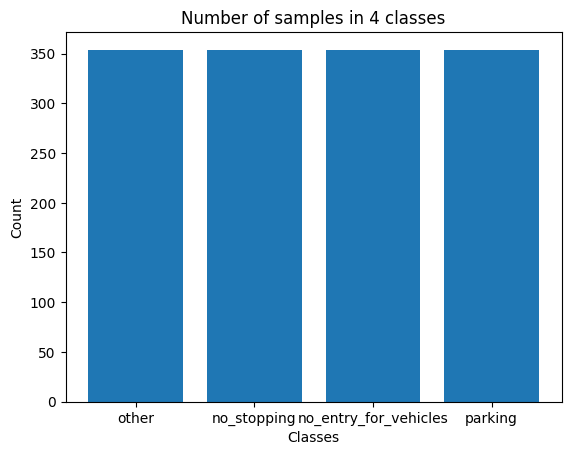

In [94]:
# Displaying count of each samples
plt.bar(list(counts.keys()), counts.values())
plt.title("Number of samples in 4 classes")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

### Image Loading and Preprocessing

#### Load Image
The `load_image` method reads an image file from the specified path using TensorFlow's I/O utilities. It decodes the image in PNG format with three color channels and converts the pixel values to floating-point format for further processing.

#### Preprocess Image
The `preprocess_image` function resizes the input image to the specified dimensions (`IMAGE_WIDTH` and `IMAGE_HEIGHT`) required for compatibility with TensorFlow's object detection models. Additionally, it performs per-image standardization, ensuring consistent pixel values across all images.

#### Preprocess Data
The `preprocess_data` method is responsible for loading and preprocessing the training data stored in a CSV file. It iterates over each row in the DataFrame, loading and preprocessing the corresponding image using the `load_image` and `preprocess_image` functions. The images are then added to the final image array, while the labels and coordinates are appended to their respective arrays. The labels are one-hot encoded using scikit-learn's `OneHotEncoder`, and the coordinates are stored as numpy arrays. Finally, the method returns the preprocessed images, encoded labels, coordinates, and decoded labels for further use in model training.


In [95]:
# Load an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # print(image.shape)
    return image

# Preprocess an image for use with a TensorFlow object detection model
def preprocess_image(image):
    image = tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    # image = image / 255.0  # Normalize the pixel values
    image = tf.image.per_image_standardization(image) 
    return image

# Load and preprocess your training data
def preprocess_data(data_csv):
    # Load and preprocess your data here
    df = pd.read_csv(data_csv)
    images = []
    labels = []
    coordinates = []
    for row in df.iterrows():
        # Load and preprocess an image
        image_path = row[1]['path']
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Add a batch dimension to the image
        # image = np.expand_dims(image, axis=0)
        # print(image.shape)
        # Appending to final image array
        images.append(np.array(image))
        
        # Appending to final coordinate array
        coordinates.append(np.array([row[1]['x1'], row[1]['y1'], row[1]['x2'], row[1]['y2']]))
    
    # labels = pd.get_dummies(np.array(labels))
    encoder = OneHotEncoder(sparse_output=False)
    encoded_labels = encoder.fit_transform(df[['label']])
    # Decode the encoded labels
    decoded_labels = encoder.inverse_transform(encoded_labels)
    
    coordinates = np.array(coordinates)
    images = np.array(images)

    return images, encoded_labels, coordinates, decoded_labels

Splitting the dataset into 80% training data and 20% testing data resulted in the following dimensions for each dataset:

- `X_train`: 1132 samples, 224x224x3
- `X_test`: 284 samples, 224x224x4
- `Y_train`: 1132 samples, 224x224x3
- `Y_test`: 284 samples, 224x224x4

It's important to note that Y_train and Y_test arrays have four dimensions to accommodate the one-hot encoding of the class labels for each sample in the dataset.

In [96]:
# Load and preprocess the data
images,labels,coordinates,decoded_labels = preprocess_data(final_data)

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}\nY_train: {Y_train.shape}\nY_test: {Y_test.shape}\n")


X_train: (1132, 224, 224, 3)
X_test: (284, 224, 224, 3)
Y_train: (1132, 4)
Y_test: (284, 4)



Decoder dictionary to convert encoded labels back to their original class labels.

In [97]:
# Creating decoder for encoding
labels_encoding_dict = {} 
for i in range(len(labels)):
    if decoded_labels[i][0] not in labels_encoding_dict.keys():
        labels_encoding_dict[decoded_labels[i][0]] = labels[i]
print(f"Total classes encoded: {len(np.unique(labels_encoding_dict.values())[0])}")

Total classes encoded: 4


In [99]:
classes = list(labels_encoding_dict.keys())
print(classes)

['other', 'no_stopping', 'no_entry_for_vehicles', 'parking']


#### Creating Models

1. **Basic Model:** This model is a custom neural network architecture designed from scratch.

2. **ResNet Model:** This model utilizes the ResNet architecture .


**Basic Model:**
The architecture is designed to capture hierarchical patterns in the input images through convolutional layers, followed by feature aggregation and classification through dense layers. It comprises convolutional layers followed by max-pooling layers, with fully connected layers at the end. Here's a breakdown of the layers and their significance:

1. **Convolutional Layers**:
   - Two convolutional layers with 32 and 64 filters, respectively, are used to extract features from the input images. A filter size of (3, 3) is chosen to capture spatial information effectively.
   - ReLU activation function is applied to introduce non-linearity, allowing the model to learn complex patterns in the data.
   - The input shape parameter specifies the shape of the input images, which is (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS). This ensures compatibility between the input data and the model architecture.

2. **MaxPooling Layers**:
   - Max-pooling layers are inserted after each convolutional layer to downsample the feature maps, reducing computational complexity and preventing overfitting.
   - A pool size of (2, 2) is chosen to retain the most significant information while reducing the spatial dimensions of the feature maps.

3. **Flatten Layer**:
   - The flatten layer is used to transform the 3D feature maps into a 1D vector, which can be fed into the fully connected layers.
   - This step is essential for transitioning from the convolutional layers to the dense layers.

4. **Dense Layers**:
   - Two dense layers are added at the end of the model architecture.
   - The first dense layer with 64 units and ReLU activation further processes the extracted features, enabling the model to learn complex patterns.
   - The second dense layer consists of NUM_CLASSES units with softmax activation, producing probability scores for each class in the classification task.



In [100]:
def create_model():
    model = tf.keras.Sequential()
    # Add some convolutional and max pooling layers
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
    return model

In [105]:
# Training Parameters
EPOCHS = 10
BS = 64
LR = 0.001

In [106]:
# Create the model
basic_model = create_model()

# Compile the model
basic_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(basic_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

In [107]:
# Fitting model
history_b = basic_model.fit(X_train, Y_train, batch_size=BS, epochs=EPOCHS)

Epoch 1/10
18/18 [==============================] - 33s 2s/step - loss: 1.4845 - accuracy: 0.7270
Epoch 2/10
18/18 [==============================] - 34s 2s/step - loss: 0.1445 - accuracy: 0.9505
Epoch 3/10
18/18 [==============================] - 31s 2s/step - loss: 0.0665 - accuracy: 0.9779
Epoch 4/10
18/18 [==============================] - 31s 2s/step - loss: 0.0279 - accuracy: 0.9929
Epoch 5/10
18/18 [==============================] - 31s 2s/step - loss: 0.0123 - accuracy: 0.9956
Epoch 6/10
18/18 [==============================] - 31s 2s/step - loss: 0.0119 - accuracy: 0.9956
Epoch 7/10
18/18 [==============================] - 31s 2s/step - loss: 0.0058 - accuracy: 0.9991
Epoch 8/10
18/18 [==============================] - 31s 2s/step - loss: 0.0024 - accuracy: 1.0000
Epoch 9/10
18/18 [==============================] - 31s 2s/step - loss: 8.7174e-04 - accuracy: 1.0000
Epoch 10/10
18/18 [==============================] - 31s 2s/step - loss: 3.3696e-04 - accuracy: 1.0000


**Training Results**
- Loss: 0.00033696
- Accuracy: 100.00%

While the accuracy steadily increased and the loss decreased with each epoch, achieving 100% accuracy raises concerns about overfitting.

In [108]:
# Saving/Loading model
basic_model.save('models/OD.h5')
# basic_model = load_model('models/OD.h5')

In [110]:
# Evaluate the model on the test set
results = basic_model.evaluate(X_test, Y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

9/9 [==============================] - 2s 248ms/step - loss: 0.1325 - accuracy: 0.9718
Test loss: 0.13250766694545746
Test accuracy: 0.9718309640884399


**Testing Results**
- Loss: 0.1325
- Accuracy: 97.18%


#### Evaluating training

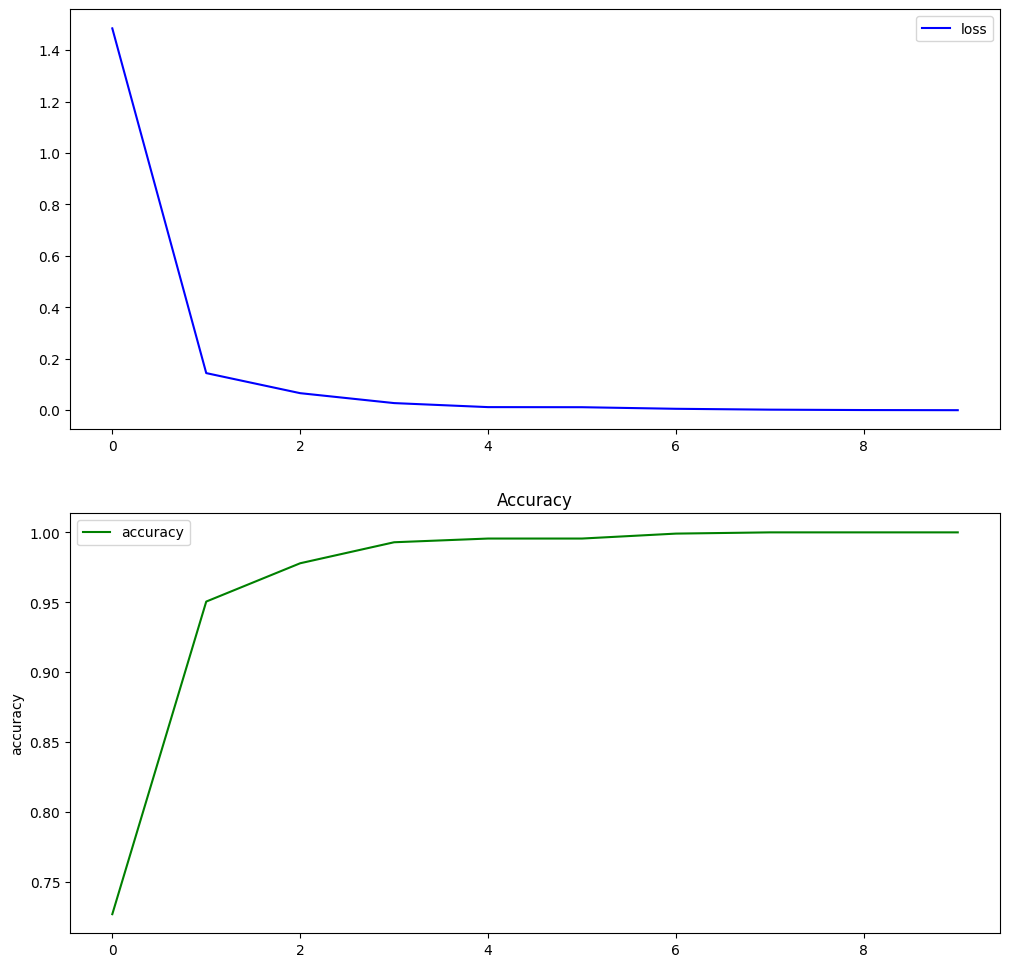

In [111]:
# Checking loss and accuracy during training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plt.title("Loss")
plt.ylabel('error')
ax1.plot(history_b.history['loss'],color = 'b',label = 'loss')
ax1.legend(['loss'])

plt.title("Accuracy")
plt.ylabel('accuracy')
ax2.plot(history_b.history['accuracy'],color = 'green',label = 'accuracy')
ax2.legend(['accuracy','val_accuracy'])
plt.show()

#### Testing on unseen data
Testing model on unseen images and saving results in new directory with bounding boxes, actual class name and predicted class name.

In [112]:
def test_preprocess(image):
    image = tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    # image = image / 255.0  # Normalize the pixel values
    image = tf.image.per_image_standardization(image) 
    return image

In [165]:
test_inp_path = "test_inp_data"
test_out_path = "test_out_data"
imgs = []
labels = []

tests = glob.glob(os.path.join(test_inp_path, '*.json'))
for test in tests:
    with open(test, 'r') as ann:
        ann_data = json.loads(ann.read()) # Reading Json file
        img_path = ann_data['imagePath']
        img = cv2.imread(os.path.join(test_inp_path,img_path))
        for shape in ann_data['shapes']:
            counter = 0
            label = shape['label']
            # [x1, y1], [x2, y2]
            x1, y1, x2, y2 = int(shape["points"][0][0]), int(shape["points"][0][1]), int(shape["points"][1][0]), int(shape["points"][1][1]) 
            cropped_img = img[y1:y2, x1:x2]
            if cropped_img is not None:
                try:
                     # Predict Result
                    processed_img = test_preprocess(img[y1:y2, x1:x2])
                    processed_img = tf.expand_dims(processed_img, axis=0)
                    result = basic_model.predict(processed_img)
                    max_value = max(result[0])
                    max_index = np.where(result[0] == max_value)
                    idx = max_index[0][0]
                    confidence = float(str (max_value)[:-5])
                    print_txt = f"{classes[idx]}({confidence})"
                    imgs.append(cropped_img)
                    labels.append(print_txt)
                    out_img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5) # Drawing rectangle
                    out_img = cv2.putText(img, print_txt, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
                    cv2.imwrite(os.path.join(test_out_path, img_path.split('.')[0] + "_" +str(counter) +"_out.png"), img)
                    counter+=1
                except:
                    pass

1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other(0.97)


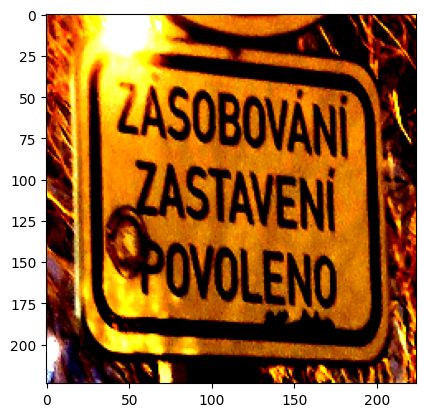

In [173]:
# Checkign result
i = 30
print(labels[i])
plt.imshow(images[i])
plt.show()

**RESNET Model:**
The second mode created is based on the **ResNet50**, a variant of the ResNet architecture. ResNet50 is a deep convolutional neural network consisting of 50 layers, including convolutional layers, pooling layers, and fully connected layers. It was introduced by Kaiming He et al. in their seminal paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).

- ResNet50 is pretrained on the **ImageNet** dataset, which contains millions of labeled images across thousands of classes. By leveraging **transfer learning**, this pretrained model can be fine-tuned for specific tasks with relatively small amounts of labeled data.

- In the provided code, **ResNet50** is used as a **feature extractor**. The pretrained **ResNet50** model is loaded, and its weights are frozen, preventing them from being updated during training. This approach allows the model to leverage the learned representations from **ImageNet** while adapting to a new task. 

- The fully connected layers added on top of the **ResNet50** base consist of a global average pooling layer followed by a dense layer with ReLU activation and another dense layer with softmax activation, which outputs the predicted class probabilities.

- By using **ResNet50** as a feature extractor and adding custom layers on top, the model benefits from the powerful feature representations learned by **ResNet50** while being tailored to the specific classification task at hand. This approach often leads to faster convergence and improved performance compared to training a model from scratch, especially when dealing with limited labeled data.


In [126]:
# Import the ResNet50 model
from tensorflow.keras.applications import ResNet50

def create_resnet_model():
    # Load the pre-trained model
    base_model = ResNet50(weights='imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), include_top=False)

    # Freeze the weights of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a few fully connected layers
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='class_output')
    ])
    
    
    return model

In [130]:
# Training Parameters
EPOCHS = 20
BS = 64
LR = 0.001

#### Compiling and training resnet model

In [131]:
resnet_model = create_resnet_model()

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(resnet_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 64)                131136    
                                                                 
 class_output (Dense)        (None, 4)                 260       
                                                                 
Total params: 23,719,108
Trainable params: 131,396
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [132]:
# Train the model
history_r = resnet_model.fit(X_train, Y_train, batch_size=BS, epochs=EPOCHS)

Epoch 1/20
18/18 [==============================] - 67s 4s/step - loss: 1.1285 - accuracy: 0.5141
Epoch 2/20
18/18 [==============================] - 65s 4s/step - loss: 0.6992 - accuracy: 0.7332
Epoch 3/20
18/18 [==============================] - 64s 4s/step - loss: 0.5588 - accuracy: 0.7933
Epoch 4/20
18/18 [==============================] - 64s 4s/step - loss: 0.4659 - accuracy: 0.8392
Epoch 5/20
18/18 [==============================] - 65s 4s/step - loss: 0.4164 - accuracy: 0.8489
Epoch 6/20
18/18 [==============================] - 66s 4s/step - loss: 0.3753 - accuracy: 0.8763
Epoch 7/20
18/18 [==============================] - 65s 4s/step - loss: 0.3452 - accuracy: 0.8896
Epoch 8/20
18/18 [==============================] - 66s 4s/step - loss: 0.3313 - accuracy: 0.8922
Epoch 9/20
18/18 [==============================] - 66s 4s/step - loss: 0.3024 - accuracy: 0.9011
Epoch 10/20
18/18 [==============================] - 79s 4s/step - loss: 0.2881 - accuracy: 0.9064
Epoch 11/20
18/18 [

The model training progressed over 20 epochs, achieving improved accuracy and reduced loss with each epoch. The accuracy steadily increased from 51.41% in the first epoch to 94.79% in the final epoch, while the loss decreased from 1.1285 to 0.1707. This indicates effective learning and convergence of the model.

**Training Results**
- Loss: 0.1707
- Accuracy: 94.79%


In [133]:
resnet_model.save('models/OD_Resnet50.h5')
resnet_model = load_model('models/OD_Resnet50.h5')

In [134]:
# Evaluate the model on the test set
results = resnet_model.evaluate(X_test, Y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

9/9 [==============================] - 19s 2s/step - loss: 0.2212 - accuracy: 0.9401
Test loss: 0.2211906611919403
Test accuracy: 0.9401408433914185


**Training Results**
- Loss: 0.22
- Accuracy: 94.01%

#### Evaluating training

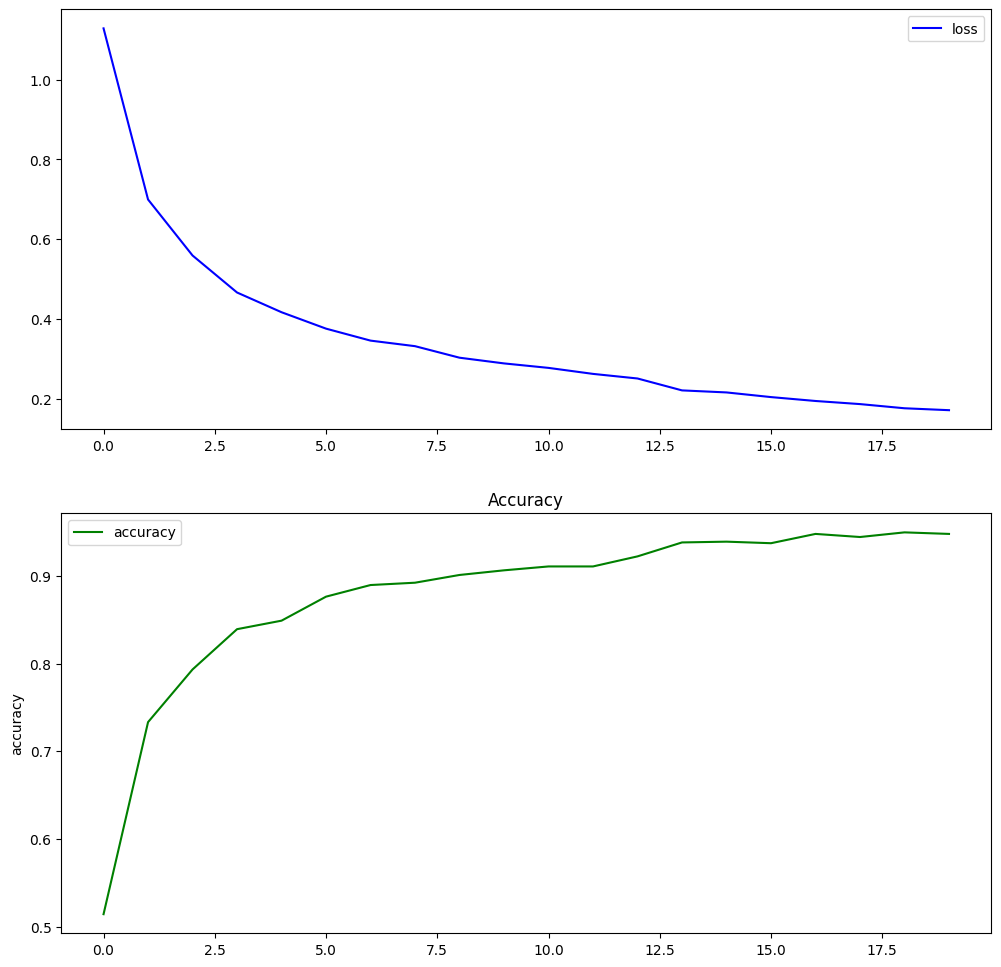

In [ ]:
# Checking loss and accuracy during training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plt.title("Loss")
plt.ylabel('error')
ax1.plot(history_r.history['loss'],color = 'b',label = 'loss')
ax1.legend(['loss'])

plt.title("Accuracy")
plt.ylabel('accuracy')
ax2.plot(history_r.history['accuracy'],color = 'green',label = 'accuracy')
# ax2.plot(history_b.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'])
plt.show()

#### Testing on unseen data
Testing model on unseen images and saving results in new directory with bounding boxes, actual class name and predicted class name.

In [138]:
def test_preprocess(image):
    image = tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    # image = image / 255.0  # Normalize the pixel values
    image = tf.image.per_image_standardization(image) 
    return image

In [139]:
test_inp_path = "test_inp_data"
test_out_path = "test_out_data"
imgs = []
labels = []

tests = glob.glob(os.path.join(test_inp_path, '*.json'))
for test in tests:
    with open(test, 'r') as ann:
        ann_data = json.loads(ann.read()) # Reading Json file
        img_path = ann_data['imagePath']
        img = cv2.imread(os.path.join(test_inp_path,img_path))
        for shape in ann_data['shapes']:
            counter = 0
            label = shape['label']
            # [x1, y1], [x2, y2]
            x1, y1, x2, y2 = int(shape["points"][0][0]), int(shape["points"][0][1]), int(shape["points"][1][0]), int(shape["points"][1][1]) 
            cropped_img = img[y1:y2, x1:x2]
            if cropped_img is not None:
                try:
                     # Predict Result
                    processed_img = test_preprocess(img[y1:y2, x1:x2])
                    processed_img = tf.expand_dims(processed_img, axis=0)
                    result = resnet_model.predict(processed_img)
                    max_value = max(result[0])
                    max_index = np.where(result[0] == max_value)
                    idx = max_index[0][0]
                    confidence = float(str (max_value)[:-5])
                    print_txt = f"{classes[idx]}({confidence})"
                    imgs.append(cropped_img)
                    labels.append(print_txt)
                    out_img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5) # Drawing rectangle
                    out_img = cv2.putText(img, print_txt, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
                    cv2.imwrite(os.path.join(test_out_path, img_path.split('.')[0] + "_" +str(counter) +"_out.png"), img)
                    counter+=1
                except:
                    pass

1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no_stopping(0.91)


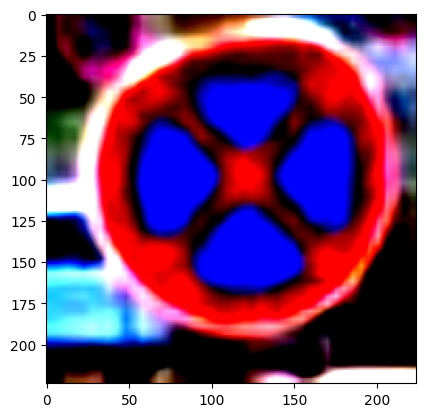

In [164]:
# Checkign result
i = 5
print(labels[i])
plt.imshow(images[i])
plt.show()

### Some Good results...

![No Stopping and No Entry Results](Good_Results/321_IMG_0_out.png)

![Parking Results](Good_Results/354_IMG_0_out.png)

![Parking Results](Good_Results/305_IMG_0_out.png)